from https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
ads = pd.read_csv(DATA_PATH + "ads.csv", index_col=["Time"], parse_dates=["Time"])
currency = pd.read_csv(
    DATA_PATH + "currency.csv", index_col=["Time"], parse_dates=["Time"]
)

In [6]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [7]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


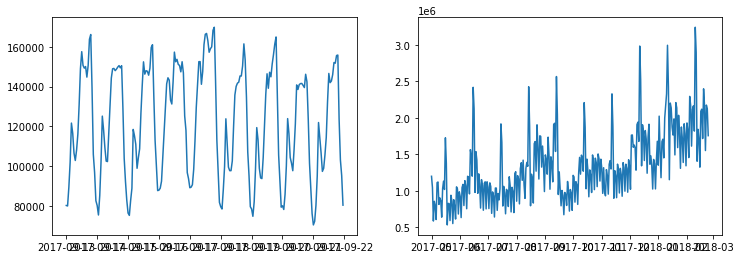

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6*2,4))
ax[0].plot(ads)
ax[1].plot(currency)

# Exponential smoothing

In [26]:
def exponential_smoothing(x, alpha):
    smoothed = x.copy()
    # first value does not change
    for i in range(1, len(smoothed)):
        smoothed[i] = X[i] * alpha + ( 1 - alpha ) * smoothed[i-1]
    return smoothed

In [99]:
ads["smoothed"] = exponential_smoothing(ads["Ads"], alpha=0.2)
currency["smoothed"] = exponential_smoothing(currency["GEMS_GEMS_SPENT"], alpha=0.2)

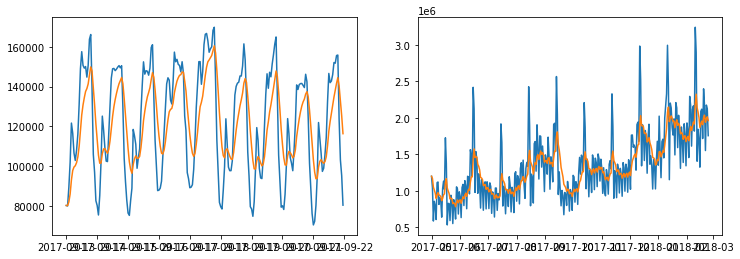

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(6*2,4))
ax[0].plot(ads[["Ads", "smoothed"]])
ax[1].plot(currency[["GEMS_GEMS_SPENT", "smoothed"]])

# Double exponential smoothing

to account for variation in trend

In [101]:
def double_exponential_smoothing(x, alpha, beta):
    # level
    l = x[0]
    # trend
    b = 0
    smoothed = np.zeros(len(x)+1)
    smoothed[0] = x[0]
    for i in range(1,len(smoothed)):
        if i==1:
            l = alpha * x[1] + (1 - alpha) * ( x[0] + 0 )# 0 is trend at i=0
            b = x[1] - x[0]
        if i>=(len(x)):# forecasting
            value = smoothed[i-1]
        else:
            value = x[i]
        l_last = l
        l = alpha * value + ( 1 - alpha ) * ( l + b )
        b = beta * (l - l_last) + (1 - beta) * b
        smoothed[i] = l + b
    return smoothed

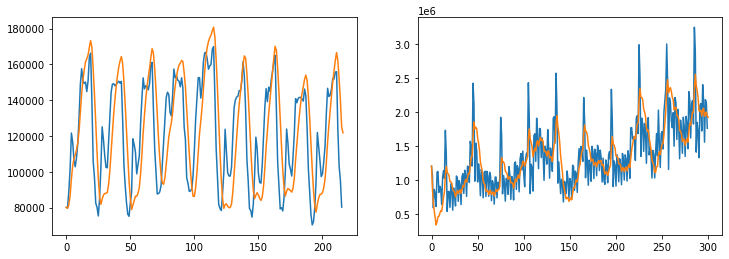

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(6*2,4))
ax[0].plot(ads["Ads"].to_numpy())
ax[0].plot(double_exponential_smoothing(ads["Ads"], alpha=0.2, beta=0.2))
ax[1].plot(currency["GEMS_GEMS_SPENT"].to_numpy())
ax[1].plot(double_exponential_smoothing(currency["GEMS_GEMS_SPENT"], alpha=0.2, beta=0.2))

# Triple exponential smoothing a.k.a. Holt-Winters

to account for seasonality

In [104]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])


# Simple linear regression with various input features

In [106]:
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(ads["Ads"].copy())
data.columns = ["y"]
data.head()

,y
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [107]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data["y"].shift(i)

In [108]:
# add hours, day number, is week end ?
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


In [130]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [131]:
y = data.dropna()["y"]
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [135]:
'''
timeseriessplit respect the order of the samples, the test set is always the same size 
but the training set increases as more folds are added
https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
'''

tscv = TimeSeriesSplit(n_splits=5)

In [136]:
# need to scale the input features as they are very different scales
# to improve convergence speed, but also use coefficient of regression to assess feature importance
model = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("Lasso", Lasso())
])

In [144]:
# distributions for hyperparameters
params = {"Lasso__alpha": loguniform(a=1, b=1000)}

In [145]:
# 10 random sampling of parameters, each tested through 5-fold cross-validation
search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params,
    n_iter=100,
    cv=tscv
)

In [146]:
CV = search.fit(X_train, y_train)

In [147]:
CV.best_params_

{'Lasso__alpha': 111.08364940476018}

In [148]:
CV.best_score_

0.7320620448671172

In [149]:
# test final model on test dataset
selected_model = CV.best_estimator_
selected_model.score(X_test, y_test)

0.9181139626867748

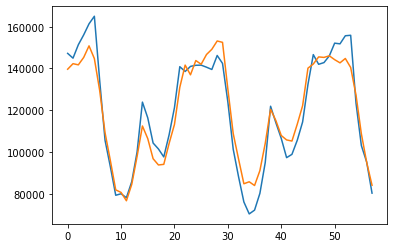

In [153]:
fig, ax = plt.subplots()
ax.plot(y_test.to_numpy())
ax.plot(selected_model.predict(X_test))

<AxesSubplot:>

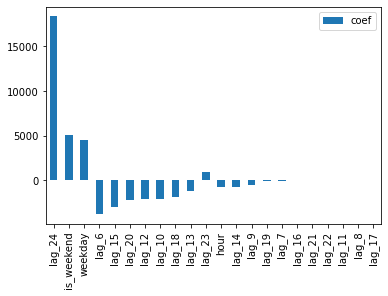

In [167]:
# feature importance
pd.DataFrame(
    data=selected_model["Lasso"].coef_, 
    index=X_train.columns, 
    columns=["coef"]
).sort_values(
    by="coef", 
    key=np.abs, 
    ascending=False
).plot.bar()